In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset , random_split

In [2]:
class Config:
    def __init__(self,mode='conv',nfilt=26,nfeat=13,nfft=512,rate=16000):
        self.mode=mode
        self.nfilt=nfilt
        self.nfeat=nfeat
        self.rate=rate
        self.nfft=nfft
        self.step=int(rate/10)
        self.min=float('inf')   
        self.max=-float('inf')

In [3]:
def plot_singals(signal):
    fig,axes = plt.subplots(nrows=2,sharex=False,sharey=True,figsize=(10,5))
    fig.suptitle("Time Series",size=16)
    z=0
    for i in range(2):
        axes[i].set_title(list(signal.keys())[z])
        axes[i].plot(list(signal.values())[z])
        z+=1
    plt.show()

In [4]:
def plot_fft(fft):
    fig,axes = plt.subplots(nrows=2,sharex=False,sharey=True,figsize=(10,5))
    fig.suptitle("Fourier Transforms",size=16)
    z=0
    for i in range(2):
        Y,freq=list(fft.values())[z]
        axes[i].set_title(list(fft.keys())[z])
        axes[i].plot(freq,Y)
        z+=1
    plt.show()

In [5]:
def plot_bank(fbank):
    fig,axes = plt.subplots(nrows=2,sharex=False,sharey=True,figsize=(10,5))
    fig.suptitle("Filter Bank Coefficient",size=16)
    z=0
    for i in range(2):
        axes[i].set_title(list(fbank.keys())[z])
        axes[i].imshow(list(fbank.values())[z],cmap='hot',interpolation='nearest')
        z+=1
    plt.show()

In [6]:
def plot_mfccs(mfcc):
    fig,axes = plt.subplots(nrows=2,sharex=False,sharey=True,figsize=(10,5))
    fig.suptitle("mfcc",size=16)
    z=0
    for i in range(2):
        axes[i].set_title(list(mfcc.keys())[z])
        axes[i].imshow(list(mfcc.values())[z],cmap='hot',interpolation='nearest')
        z+=1
    plt.show()

In [7]:
def calc_fft(y,rate):
    n=len(y)
    freq=np.fft.rfftfreq(n,d=1/rate)
    Y=abs(np.fft.rfft(y)/n)
    return(Y,freq)

In [8]:
def envelope(y,rate,threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean=y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else :
            mask.append(False)
    return mask

In [9]:
data=[]
for i in range(1,1088):
    rate,signal =wavfile.read("happy/happy-{0:>04}.wav".format(i))
    data.append(["happy/happy-{0:>04}.wav".format(i),"happy",signal.shape[0]/rate])
for i in range(1,1088):
    rate,signal =wavfile.read("sad/sad-{0:>04}.wav".format(i))
    data.append(["sad/sad-{0:>04}.wav".format(i),"sad",signal.shape[0]/rate])
df = pd.DataFrame(data,columns=["namafile","label","length"])
df.set_index('namafile',inplace=True)
df

,label,length
namafile,,
happy/happy-0001.wav,happy,2.369000
happy/happy-0002.wav,happy,2.936250
happy/happy-0003.wav,happy,2.869500
happy/happy-0004.wav,happy,2.102125
happy/happy-0005.wav,happy,2.335688
...,...,...
sad/sad-1083.wav,sad,2.936250
sad/sad-1084.wav,sad,2.902875
sad/sad-1085.wav,sad,1.768438


In [10]:
classes = list(np.unique(df["label"]))
class_dist=df.groupby(['label'])['length'].mean()
class_dist

label
happy    2.342911
sad      2.592581
Name: length, dtype: float64

In [11]:
df.reset_index(inplace=True)

In [12]:
signals={}
fft={}
fbank={}
mfcc={}

In [13]:
for i in classes:
    wav_file=df[df.label==i].iloc[0,0]
    signal,rate=librosa.load(wav_file,sr=16000)
    mask = envelope(signal,rate,0.0005)
    signal=signal[mask]
    signals[i]=signal
    fft[i]=calc_fft(signal,rate)
    logfbank = librosa.feature.melspectrogram(y=signal,sr=rate,n_mels=26,n_fft=512)
    fbank[i]=librosa.power_to_db(logfbank)
    temp=librosa.feature.mfcc(y=signal,sr=rate,n_mels=128,n_fft=512,n_mfcc=13)
    mfcc[i]=librosa.power_to_db(temp)



In [14]:
print(mfcc["happy"].shape)
print(mfcc["sad"].shape)

(13, 75)
(13, 94)


In [15]:
happy=1
sad=1
for i in df.iterrows():
    wav_file=i[1]["namafile"]
    signal,rate=librosa.load(wav_file,sr=16000)
    mask = envelope(signal,rate,0.0005)
    signal=signal[mask]
    if i[1]["label"]=="happy":
        wavfile.write("./filtered/{}-{}.wav".format("happy",happy),16000,signal)
        happy+=1
    else:
        wavfile.write("./filtered/{}-{}.wav".format("sad",sad),16000,signal)
        sad+=1

    

In [16]:
cleandata=[]
for i in range(1,1088):
    rate,signal =wavfile.read("filtered/happy-{0}.wav".format(i))
    cleandata.append(["filtered/happy-{0}.wav".format(i),"happy",signal.shape[0]/rate,rate,signal])
for i in range(1,1088):
    rate,signal =wavfile.read("filtered/sad-{0}.wav".format(i))
    cleandata.append(["filtered/sad-{0}.wav".format(i),"sad",signal.shape[0]/rate,rate,signal])
cleandf = pd.DataFrame(cleandata,columns=["namafile","label","length","rate","signal"])
cleandf

,namafile,label,length,rate,signal
0,filtered/happy-1.wav,happy,2.369000,16000,"[-0.0017089844, -0.0018310547, -0.001953125, -..."
1,filtered/happy-2.wav,happy,2.936250,16000,"[-0.0010375977, -0.00076293945, 0.0, 0.0007934..."
2,filtered/happy-3.wav,happy,2.869500,16000,"[0.008636475, 0.008636475, 0.009857178, 0.0106..."
3,filtered/happy-4.wav,happy,2.102125,16000,"[0.0030212402, 0.0028076172, 0.0035705566, 0.0..."
4,filtered/happy-5.wav,happy,2.335688,16000,"[-0.003753662, -0.00390625, -0.003753662, -0.0..."
...,...,...,...,...,...
2169,filtered/sad-1083.wav,sad,2.936250,16000,"[-0.010894775, -0.0119018555, -0.012481689, -0..."
2170,filtered/sad-1084.wav,sad,2.902875,16000,"[-0.0063476562, -0.0057373047, -0.005279541, -..."
2171,filtered/sad-1085.wav,sad,1.768438,16000,"[0.008117676, 0.00793457, 0.009338379, 0.00967..."
2172,filtered/sad-1086.wav,sad,2.602625,16000,"[-0.0046691895, -0.006225586, -0.005218506, -0..."


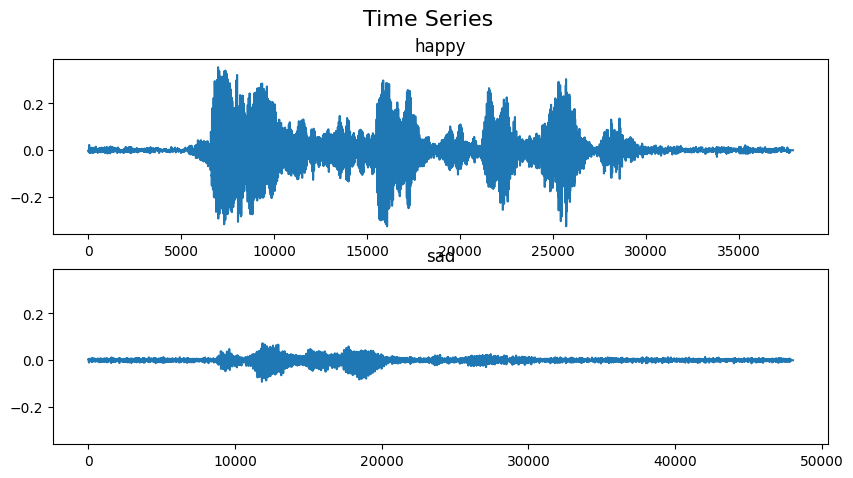

In [17]:
plot_singals(signal=signals)

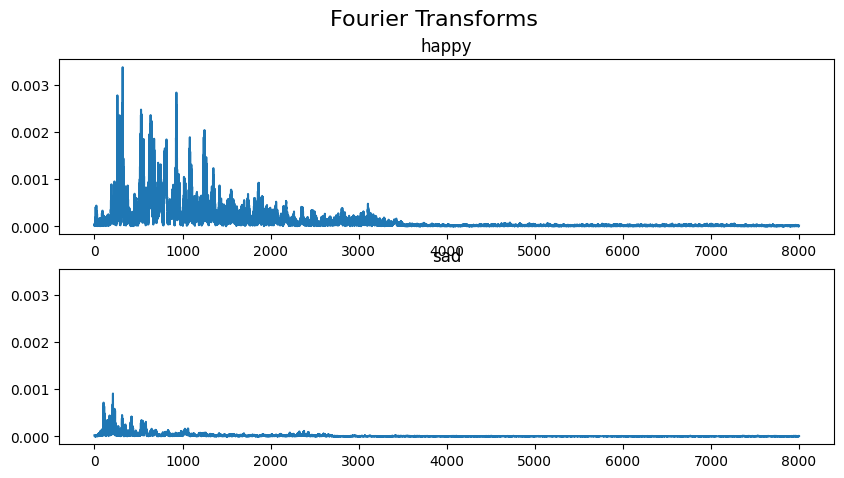

In [18]:
plot_fft(fft)

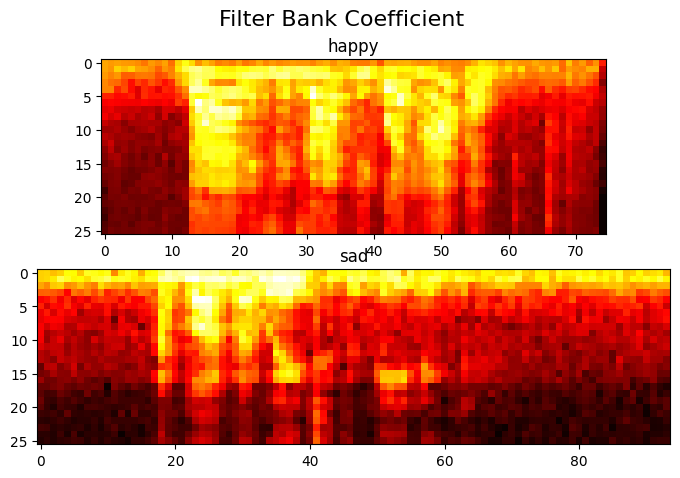

In [19]:
plot_bank(fbank)

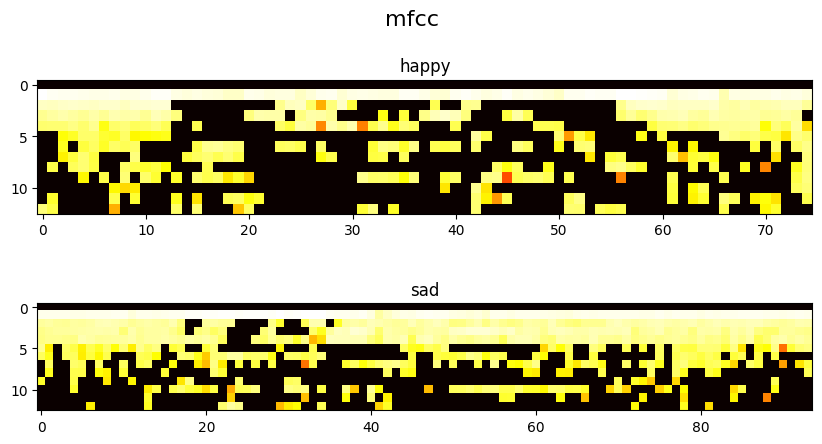

In [20]:
plot_mfccs(mfcc)

In [21]:
n_sample=2*int(df['length'].sum()/0.1)

In [22]:
prop_dist=class_dist / class_dist.sum()
prop_dist

label
happy    0.474707
sad      0.525293
Name: length, dtype: float64

In [23]:
config=Config(mode='conv')

In [24]:
mfcc["sad"].shape

(13, 94)

In [25]:
s=cleandf["signal"].iloc[0]


In [26]:

# def build_rand_feat():
#     x=[]
#     y=[]
#     _min,_max=float('inf'),-float('inf')
#     for _ in tqdm(range(n_sample)):
#         rand_class=np.random.choice(class_dist.index,p=prop_dist)
#         data=np.random.choice(cleandf[cleandf.label==rand_class].index)
#         data=cleandf.iloc[data]
#         rate=data["rate"]
#         wav=data["signal"]
#         label=data["label"]
#         rand_index=np.random.randint(0,wav.shape[0]-config.step)
#         sample=wav[rand_index:rand_index+config.step]
#         X_sample=librosa.feature.mfcc(y=sample,sr=rate,n_mels=config.nfilt,n_fft=config.nfft,n_mfcc=config.nfeat)
#         X_sample=librosa.power_to_db(X_sample)
#         _min = min(np.amin(X_sample),_min)
#         _max = max(np.amax(X_sample),_max)
#         x.append(X_sample if config.mode =='conv' else X_sample.T)
#         y.append(classes.index(label))
#     X,Y =np.array(x),np.array(y)
#     X=(X-_min)/(_max-_min)
#     config.max=_max
#     config.min=_min
#     if config.mode == 'conv':
#         X=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
#     elif config.mode == 'time':
#         X=X.reshape(X.shape[0],X.shape[1],X.shape[2])
#     num_classes=len(np.unique(Y))
#     Y=np.eye(num_classes)[Y]
#     return (X,Y)

In [27]:
# def mfcc(audio, n_mels,sr,n_fft=2048, hop=400, n_mfcc=25):

#     mfcc_spectrum = librosa.feature.mfcc(y=audio, sr=sr, n_fft=n_fft, hop_length=hop, n_mfcc=n_mfcc,n_mels=n_mels)

#     delt1 = librosa.feature.delta(mfcc_spectrum, order=1)
#     delt2 = librosa.feature.delta(mfcc_spectrum, order=2)

#     mfcc_feature = np.concatenate((np.mean(mfcc_spectrum, axis=1), np.mean(delt1, axis=1), np.mean(delt2, axis=1)))

#     return mfcc_feature

In [28]:
pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]),dtype=np.float32)))
def build_rand_feat():
    x=[]
    y=[]
    _min,_max=float('inf'),-float('inf')
    for i in tqdm(range(len(cleandf))):
        sample=cleandf["signal"].iloc[i]
        X_sample=librosa.feature.mfcc(y=sample,sr=rate,n_mels=config.nfilt,n_fft=config.nfft,n_mfcc=config.nfeat)
        X_sample=pad2d(X_sample,60)
        X_sample=librosa.power_to_db(X_sample)
        _min = min(np.amin(X_sample),_min)
        _max = max(np.amax(X_sample),_max)
        x.append(X_sample if config.mode =='conv' else X_sample.T)
        y.append(classes.index(cleandf["label"].iloc[i]))
    X,Y =np.array(x),np.array(y)
    X=(X-_min)/(_max-_min)
    if config.mode == 'conv':
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode == 'time':
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2])
    config.max=_max
    config.min=_min
    num_classes=len(np.unique(Y))
    Y=np.eye(num_classes)[Y]
    return (X,Y)

In [29]:
if config.mode=='conv':
    X,y =build_rand_feat()
elif config.mode=='time':
    X,y=build_rand_feat()


100%|██████████| 2174/2174 [00:03<00:00, 638.44it/s]


In [30]:
X.shape

(2174, 13, 60, 1)

*MAKE the model and the data loader*

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class AudioDatasets(Dataset):
    def __init__(self,data,labels):
        self.data=data
        self.labels=labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        sample=self.data[index]
        label=self.labels[index]
        return (sample , label)


In [32]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
def accuracy(test_dataloader,model):
    correct = 0
    total = 0
    avgf1=0
    avgpre=0
    avgrec=0
    # Set the model to evaluation mode
    model.eval()
    totalbatch=0
    # Disable gradient calculation
    with torch.no_grad():
        for images, labels in test_dataloader:
            # Move the data to the device (e.g., GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            _, true_labels = torch.max(labels.data, 1)

            prenump=predicted.cpu()
            truenump=true_labels.cpu()
            prenump=prenump.numpy()
            truenump=truenump.numpy()
            # Count the correct predictions
            correct += (predicted == true_labels).sum().item()
            avgf1+=f1_score(truenump,prenump)
            avgpre+=precision_score(truenump,prenump)
            avgrec+=recall_score(truenump,prenump)
            # Count the total number of examples
            total += labels.size(0)
            totalbatch+=1
    # Calculate the accuracy
    accuracy = 100 * correct / total
    model.train()
    return accuracy , avgf1/totalbatch ,avgrec/totalbatch ,avgpre/totalbatch

In [33]:

class AudioClassifiers(nn.Module):
    def __init__(self,inputsize=13, *args, **kwargs) :
        super(AudioClassifiers,self).__init__(*args, **kwargs)
        self.Conv2D1=nn.Conv2d(inputsize,16,3,1,2).to(device=device)
        self.Relu1 = nn.ReLU().to(device=device).to(device).to(device=device)
        self.Conv2D2=nn.Conv2d(16,32,3,1,2).to(device=device)
        self.Relu2 = nn.ReLU().to(device=device)
        # self.Conv2D3=nn.Conv2d(32,64,3,1,2).to(device=device)
        # self.Relu3 = nn.ReLU().to(device=device)
        # self.Conv2D4=nn.Conv2d(64,128,3,1,2).to(device=device)
        # self.Relu4 = nn.ReLU().to(device=device)
        self.Maxpool=nn.MaxPool2d(2).to(device=device)
        self.Dropout=nn.Dropout(0.5).to(device=device)
        self.flatten=nn.Flatten(start_dim=1).to(device=device)
        # self.Denseex1=nn.Linear(17408,8192).to(device=device)
        # self.Reluex1 = nn.ReLU().to(device=device)
        # self.Denseex2=nn.Linear(8192,2048).to(device=device)
        # self.Reluex2 = nn.ReLU().to(device=device)
        self.Dense1=nn.Linear(2048,128).to(device=device)
        self.Relu5 = nn.ReLU().to(device=device)
        self.Dense2=nn.Linear(128,64).to(device=device)
        self.Relu6 = nn.ReLU().to(device=device)
        self.Dense3=nn.Linear(64,32).to(device=device)
        self.Relu7 = nn.ReLU().to(device=device)
        self.Dense4=nn.Linear(32,2).to(device=device)
        self.softmax = nn.Softmax(dim=1).to(device=device)
    def forward(self,msk,batch_size=1):
        msk=self.Conv2D1(msk)
        msk=self.Relu1(msk)
        msk=self.Conv2D2(msk)
        msk=self.Relu2(msk)
        # msk=self.Conv2D3(msk)
        # msk=self.Relu3(msk)
        # msk=self.Conv2D4(msk)
        # msk=self.Relu4(msk)
        msk=self.Maxpool(msk)

        msk=self.Dropout(msk)
        msk=self.flatten(msk)
        # print(msk.size())


        # msk=self.Denseex1(msk)
        # msk=self.Reluex1(msk)
        # msk=self.Denseex2(msk)
        # msk=self.Reluex2(msk)        
        msk=self.Dense1(msk)
        msk=self.Relu5(msk)       
        msk=self.Dense2(msk)
        msk=self.Relu6(msk)  
        msk=self.Dense3(msk)
        msk=self.Relu7(msk)
        msk=self.Dense4(msk)
        out=self.softmax(msk)
        return out                           


In [34]:
train_ratio = 0.8
test_ratio = 0.2
dataset=AudioDatasets(torch.tensor(X,device=device),torch.tensor(y,device=device))
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
batch_size = 32
shuffle = True
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [52]:
learning_data={}
learning_data["accuracy"]=[]
learning_data["recall"]=[]
learning_data["f1"]=[]
learning_data["precision"]=[]
learning_data["epoch"]=[]
bestacc=0
learning_rate = 0.0001
num_epochs = 201
model=AudioClassifiers()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    running_loss = 0.0
    for sample,label in train_dataloader:
        optimizer.zero_grad()
        outputs = model(sample,32)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print average loss for the epoch
    print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_dataloader)}")
    acc,f1,rec,pre = accuracy(test_dataloader,model)
    print("accuracy:{} f1: {} recall: {} precision:{}".format(acc,f1*100,rec*100,pre*100))
    if bestacc<acc:
        bestacc=acc
        with open("best.txt","w") as file:
            file.write("accuracy:{} f1: {} recall: {} precision:{} epoch:{}".format(acc,f1*100,rec*100,pre*100,epoch))
            file.close()
        torch.save(model.state_dict(), "audio_classifier_best.pth")
    if epoch%20==0:
        bestacc=acc
        learning_data["accuracy"].append(acc)
        learning_data["recall"].append(rec*100)
        learning_data["f1"].append(f1*100)
        learning_data["precision"].append(pre*100)
        learning_data["epoch"].append(epoch)
        with open("./epoch_data/epoch-{}.txt".format(epoch),"w") as file:
            file.write("accuracy:{} f1: {} recall: {} precision:{}".format(acc,f1*100,rec*100,pre*100))
            file.close()
        torch.save(model.state_dict(), "./epoch_data/audio_classifier_epoch-{}.pth".format(epoch))

# torch.save(model.state_dict(), "audio_classifier.pth")


# Save the trained model

Epoch 1 - Loss: 0.6929847395093727
accuracy:49.88505747126437 f1: 0.6636370451987131 recall: 1.0 precision:0.5011748120300752
Epoch 2 - Loss: 0.6915260036252746
accuracy:68.73563218390805 f1: 0.7545091071339457 recall: 0.978295484860611 precision:0.6193818807716323
Epoch 3 - Loss: 0.6817404106998247
accuracy:54.48275862068966 f1: 0.6848526649943071 recall: 1.0 precision:0.525701759198303
Epoch 4 - Loss: 0.6356474202049296
accuracy:77.01149425287356 f1: 0.7684222890943012 recall: 0.7840370005811181 precision:0.7658721506023584
Epoch 5 - Loss: 0.5687639016304011
accuracy:75.63218390804597 f1: 0.7792316221238875 recall: 0.8726245509858955 precision:0.7123060884272737
Epoch 6 - Loss: 0.5338134589551156
accuracy:80.0 f1: 0.7797797554709998 recall: 0.7314367938317516 precision:0.8545850713613872
Epoch 7 - Loss: 0.5143305704013006
accuracy:77.47126436781609 f1: 0.7789737232055697 recall: 0.8168234484936167 precision:0.7542646406388643
Epoch 8 - Loss: 0.5039578559092623
accuracy:77.70114942528

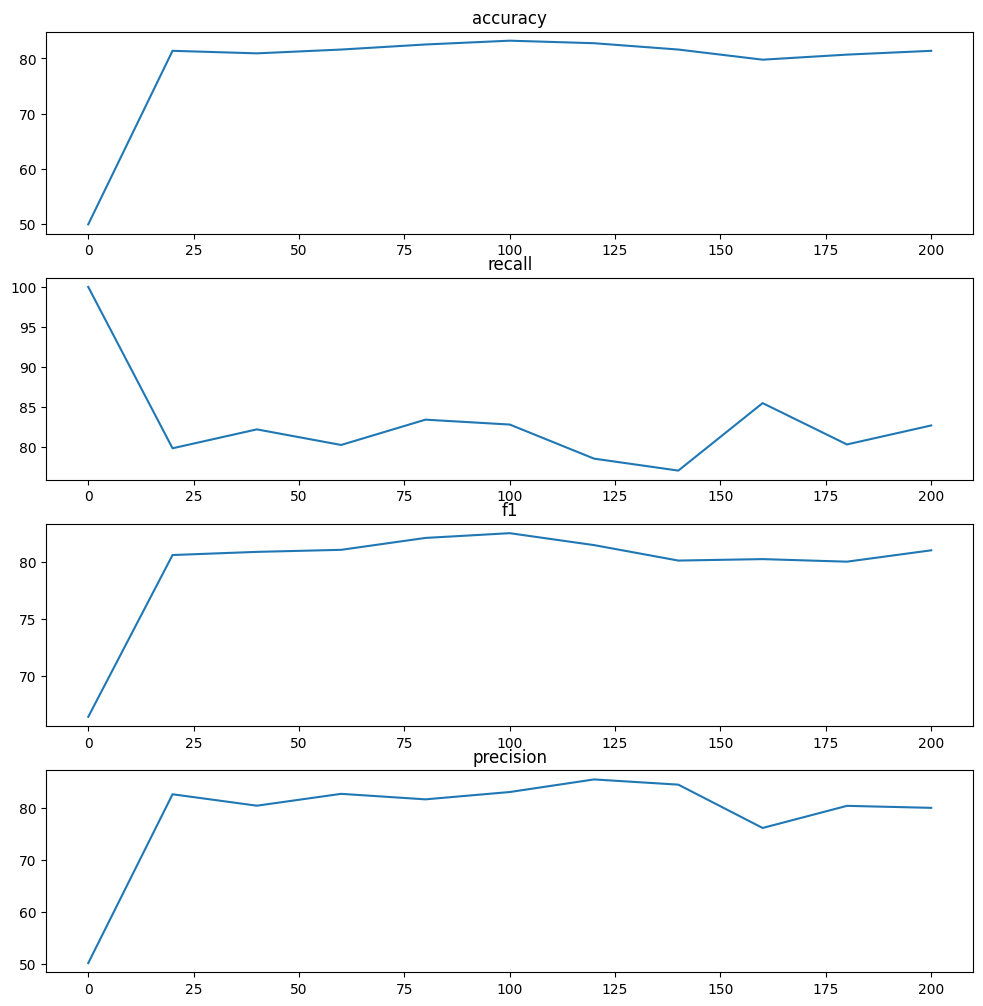

In [58]:
df = pd.DataFrame(learning_data)
df.set_index("epoch",inplace=True)
fig,ax=plt.subplots(nrows=4)
fig.set_size_inches(10,10)
plt.tight_layout()
for z,i in enumerate(df,0):
    ax[z].plot(df[i],label=i)
    ax[z].title.set_text(i)
plt.show()

In [ ]:
import pickle
with open('config.pkl','wb') as outp:
    pickle.dump(config, outp, pickle.HIGHEST_PROTOCOL)
print(config)

In [ ]:
models=AudioClassifiers()
models.load_state_dict(torch.load("audio_classifier.pth"))
models.eval()

AudioClassifiers(
  (Conv2D1): Conv2d(13, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (Relu1): ReLU()
  (Conv2D2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (Relu2): ReLU()
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=2048, out_features=128, bias=True)
  (Relu5): ReLU()
  (Dense2): Linear(in_features=128, out_features=64, bias=True)
  (Relu6): ReLU()
  (Dense3): Linear(in_features=64, out_features=32, bias=True)
  (Relu7): ReLU()
  (Dense4): Linear(in_features=32, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)